In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import os


In [5]:
Carga_Datos = pd.read_csv(r"C:\Users\dfgom\OneDrive\Escritorio\USRP\RFI_Captura\Salida\outputprueba2.csv")

### Datos temporales para pruebas 


In [ ]:
# datos para las pruebas:
# data = {'Frecuencia (Hz)': [90000000.0, 90000000.0, 90000000.0, 130000000.0, 130000000.0, 130000000.0, 130000000.0, 130000000.0, 110000000.0, 110000000.0, 110000000.0, 110000000.0, 170000000.0, 170000000.0, 170000000.0, 150000000.0, 150000000.0, 190000000.0, 190000000.0, 190000000.0, 90000000.0, 90000000.0, 90000000.0, 90000000.0],
#         'dB': [50, 25, 36, 26, 27, 26, 98, 27, 23, 46, 93, 68, 126, 30, 129, 119, 69, 114, 89, 69, 63, 27, 96, 78]}

data = {
    'Frecuencia (Hz)': [90000000.0, 90000000.0, 90000000.0, 110000000.0, 110000000.0,
                         110000000.0, 110000000.0, 130000000.0, 130000000.0, 130000000.0,
                         130000000.0, 130000000.0, 150000000.0, 150000000.0, 170000000.0,
                         170000000.0, 170000000.0, 190000000.0, 190000000.0, 190000000.0,
                         90000000.0, 90000000.0, 90000000.0, 90000000.0, 110000000.0, 110000000.0,
                         130000000.0, 150000000.0, 150000000.0,170000000.0, 190000000.0, 190000000.0, 90000000.0,90000000.0,90000000.0],
    'dB': [50, 25, 36, 26, 27, 26, 98, 27, 23, 46, 93, 68, 126, 30, 129, 119, 69, 114, 89, 69, 63, 27, 96, 78, 98,77,88,99, 27,-11,-22,-33,-5555,-1111,-2222]
}

Carga_Datos = pd.DataFrame(data)
print(Carga_Datos)

###  Borra los primeros datos con caracteres vacíos o nulos  

|Frecuencia (Hz)|        dB        |
|---------------|------------------|
|    nan        |-101.9620361328125|


In [6]:
Carga_Datos= Carga_Datos.dropna(subset=['Frecuencia (Hz)'])
# print(Carga_Datos['Frecuencia (Hz)'].mean())

### Cantidad total de datos por cada frecuencia     


In [7]:
conteo_frecuencia = Carga_Datos['Frecuencia (Hz)'].value_counts()
print(conteo_frecuencia)

Frecuencia (Hz)
90000000.0     245760
130000000.0    221184
150000000.0    221184
190000000.0    212992
110000000.0    204800
170000000.0    172032
Name: count, dtype: int64


### Separación de muestras por cada frecuencia  

In [8]:
recuentos_por_muestra = {}

# Convertir la columna 'Frecuencia (Hz)' en un arreglo NumPy
frecuencias = Carga_Datos['Frecuencia (Hz)'].values

# Inicializar variables para llevar el seguimiento de la muestra actual y el conteo actual
muestra_actual = None
conteo_actual = 0

for frecuencia in frecuencias:
    if muestra_actual is None:
        muestra_actual = frecuencia
        conteo_actual = 1
    elif muestra_actual == frecuencia:
        conteo_actual += 1
    else:
        if muestra_actual not in recuentos_por_muestra:
            recuentos_por_muestra[muestra_actual] = []
        recuentos_por_muestra[muestra_actual].append(conteo_actual)
        
        muestra_actual = frecuencia
        conteo_actual = 1

# Agregar el último conjunto de conteos a la salida
if muestra_actual is not None:
    if muestra_actual not in recuentos_por_muestra:
        recuentos_por_muestra[muestra_actual] = []
    recuentos_por_muestra[muestra_actual].append(conteo_actual)

for muestra, conteos in recuentos_por_muestra.items():
    print(f'Frecuencia: {muestra} - Conteos: {", ".join(map(str, conteos))}')

Frecuencia: 90000000.0 - Conteos: 8192, 16384, 16384, 24576, 16384, 16384, 8192, 16384, 16384, 16384, 16384, 8192, 16384, 16384, 16384, 16384
Frecuencia: 110000000.0 - Conteos: 8192, 8192, 8192, 16384, 16384, 8192, 16384, 8192, 16384, 16384, 16384, 16384, 16384, 16384, 8192, 8192
Frecuencia: 130000000.0 - Conteos: 16384, 16384, 8192, 8192, 8192, 16384, 16384, 16384, 8192, 16384, 16384, 16384, 16384, 16384, 16384, 8192
Frecuencia: 150000000.0 - Conteos: 8192, 16384, 8192, 16384, 16384, 16384, 16384, 16384, 8192, 16384, 16384, 16384, 16384, 16384, 16384
Frecuencia: 170000000.0 - Conteos: 16384, 8192, 16384, 8192, 8192, 16384, 8192, 16384, 8192, 8192, 8192, 16384, 8192, 16384, 8192
Frecuencia: 190000000.0 - Conteos: 16384, 16384, 8192, 16384, 8192, 16384, 16384, 8192, 16384, 16384, 16384, 8192, 16384, 16384, 16384


#  Tratado de datos 

### --------------------------------------------------------------------------------------------------------------------------------------------------------

Para poder tratar los datos se dividen por grupos esos hacen referencia a las muestras que se toman, para posteriormente sacar el promedio de estos y el los máximos 

In [9]:
def dividir_y_guardar_grupos(Carga_Datos, carpeta_salida):
    grupos = []
    grupo_actual = None
    cambios = np.where(Carga_Datos['Frecuencia (Hz)'].values[:-1] > Carga_Datos['Frecuencia (Hz)'].values[1:])[0]

    inicio = 0
    for cambio in cambios:
        grupo_actual = Carga_Datos.iloc[inicio:cambio + 1]
        grupos.append(grupo_actual)
        inicio = cambio + 1

    grupo_actual = Carga_Datos.iloc[inicio:]
    grupos.append(grupo_actual)

    # Crear la carpeta de salida si no existe
    if not os.path.exists(carpeta_salida):
        os.makedirs(carpeta_salida)

    # Guardar los grupos en archivos CSV
    for i, grupo in enumerate(grupos):
        nombre_archivo = os.path.join(carpeta_salida, f'Muestra_{i + 1}.csv')
        grupo.to_csv(nombre_archivo, index=False)
        print(f"Grupo {i + 1} guardado en '{nombre_archivo}'")

carpeta_muestras = 'Muestras'
dividir_y_guardar_grupos(Carga_Datos, carpeta_muestras)


Grupo 1 guardado en 'Muestras\Muestra_1.csv'
Grupo 2 guardado en 'Muestras\Muestra_2.csv'
Grupo 3 guardado en 'Muestras\Muestra_3.csv'
Grupo 4 guardado en 'Muestras\Muestra_4.csv'
Grupo 5 guardado en 'Muestras\Muestra_5.csv'
Grupo 6 guardado en 'Muestras\Muestra_6.csv'
Grupo 7 guardado en 'Muestras\Muestra_7.csv'
Grupo 8 guardado en 'Muestras\Muestra_8.csv'
Grupo 9 guardado en 'Muestras\Muestra_9.csv'
Grupo 10 guardado en 'Muestras\Muestra_10.csv'
Grupo 11 guardado en 'Muestras\Muestra_11.csv'
Grupo 12 guardado en 'Muestras\Muestra_12.csv'
Grupo 13 guardado en 'Muestras\Muestra_13.csv'
Grupo 14 guardado en 'Muestras\Muestra_14.csv'
Grupo 15 guardado en 'Muestras\Muestra_15.csv'
Grupo 16 guardado en 'Muestras\Muestra_16.csv'


# Tratado de las muestras 

Asignación de las frecuencias para cada muestra, teniendo en cuenta el ancho de banda 

Frec_max-Frec_min/cont_frec-1


In [10]:
carpeta = r'C:\Users\dfgom\OneDrive\Escritorio\USRP\RFI_Captura\Salida\Muestras'  
archivos_csv = [archivo for archivo in os.listdir(carpeta) if archivo.endswith('.csv')]

BW_TEMP = 0
MST_ANT = False

# Procesar cada archivo CSV en la carpeta
for archivo_csv in archivos_csv:
    archivo_path = os.path.join(carpeta, archivo_csv)
    data = pd.read_csv(archivo_path)

    # Identificar las secuencias de frecuencias iguales
    secuencias = data['Frecuencia (Hz)'].unique()

    # Calcular el valor de BW
    if len(secuencias) >= 2: # REVISA SI HAY OTRA FRECUENCIA 
        BW = (secuencias[1] - secuencias[0])
        BW_TEMP = BW
        MST_ANT = True
        
    elif (MST_ANT == True):
        BW = BW_TEMP

    else:               # si no no hubo una muestra anterior y no tiene un valor de BW lo tomara por defecto como 20M.
        BW = 20000000

    # Crear un nuevo DataFrame para los resultados
    nuevo_df = pd.DataFrame(columns=['Frecuencia (Hz)', 'dB'])

    # Calcular y agregar los nuevos valores de frecuencia 
    for secuencia in secuencias:
        num_samples = (data['Frecuencia (Hz)'] == secuencia).sum()
        
        min_value = secuencia - (BW / 2)
        max_value = secuencia + (BW / 2)

        # Asegurar que num_samples sea al menos 2
        if num_samples == 1:
            num_samples = 2

        incremento_frec = BW / (num_samples - 1)
        nuevos_valores_frecuencia = min_value + np.arange(num_samples) * incremento_frec
        nuevos_valores_frecuencia = pd.Series(nuevos_valores_frecuencia)
        nuevos_valores_frecuencia.name = 'Frecuencia (Hz)'
        nuevo_df = pd.concat([nuevo_df, pd.concat([nuevos_valores_frecuencia, data[data['Frecuencia (Hz)'] == secuencia]['dB'].reset_index(drop=True)], axis=1)], ignore_index=True)

    # Ordenar el nuevo DataFrame por frecuencia
    nuevo_df.sort_values(by=['Frecuencia (Hz)'], inplace=True)

    # Reiniciar los índices del nuevo DataFrame
    nuevo_df.reset_index(drop=True, inplace=True)

    # Sobreescribir el archivo CSV original con los nuevos datos
    nuevo_df.to_csv(archivo_path, index=False)

    print(f'Archivo procesado y sobrescrito: {archivo_path}')


Archivo procesado y sobrescrito: C:\Users\dfgom\OneDrive\Escritorio\USRP\RFI_Captura\Salida\Muestras\Muestra_1.csv
Archivo procesado y sobrescrito: C:\Users\dfgom\OneDrive\Escritorio\USRP\RFI_Captura\Salida\Muestras\Muestra_10.csv
Archivo procesado y sobrescrito: C:\Users\dfgom\OneDrive\Escritorio\USRP\RFI_Captura\Salida\Muestras\Muestra_11.csv
Archivo procesado y sobrescrito: C:\Users\dfgom\OneDrive\Escritorio\USRP\RFI_Captura\Salida\Muestras\Muestra_12.csv
Archivo procesado y sobrescrito: C:\Users\dfgom\OneDrive\Escritorio\USRP\RFI_Captura\Salida\Muestras\Muestra_13.csv
Archivo procesado y sobrescrito: C:\Users\dfgom\OneDrive\Escritorio\USRP\RFI_Captura\Salida\Muestras\Muestra_14.csv
Archivo procesado y sobrescrito: C:\Users\dfgom\OneDrive\Escritorio\USRP\RFI_Captura\Salida\Muestras\Muestra_15.csv
Archivo procesado y sobrescrito: C:\Users\dfgom\OneDrive\Escritorio\USRP\RFI_Captura\Salida\Muestras\Muestra_16.csv
Archivo procesado y sobrescrito: C:\Users\dfgom\OneDrive\Escritorio\USRP\

# Genera los plots de las muestras por separado 

In [ ]:

carpeta_datos = r"C:\Users\dfgom\OneDrive\Escritorio\USRP\RFI_Captura\Salida\Muestras\Muestra_tratadas"

# Crear la carpeta 'plots' si no existe
carpeta_plots = os.path.join(carpeta_datos, "plots")
os.makedirs(carpeta_plots, exist_ok=True)

# Lista de archivos CSV en la carpeta de datos
archivos_csv = [archivo for archivo in os.listdir(carpeta_datos) if archivo.endswith(".csv")]

# Función para dividir los datos en grupos de 2000
def dividir_en_grupos(datos):
    grupos = []
    grupo_actual = []
    for i, fila in enumerate(datos):
        grupo_actual.append(fila)
        if (i + 1) % 1000 == 0:
            grupos.append(grupo_actual)
            grupo_actual = []
    if grupo_actual:
        grupos.append(grupo_actual)
    return grupos

# Procesar cada archivo CSV
for archivo_csv in archivos_csv:
    # Leer el archivo CSV
    ruta_csv = os.path.join(carpeta_datos, archivo_csv)
    df = pd.read_csv(ruta_csv)

    # Dividir los datos en grupos de 2000
    grupos = dividir_en_grupos(df.values)

    # Generar y guardar los gráficos para cada grupo
    for i, grupo in enumerate(grupos):
        plt.figure(figsize=(18, 8))
        x = [fila[0] for fila in grupo]
        y = [fila[1] for fila in grupo]
        plt.plot(x, y)
        plt.xlabel("Frecuencia (Hz)")
        plt.ylabel("dB")
        plt.title(f"Gráfico {i + 1} - {archivo_csv}")
        ruta_plot = os.path.join(carpeta_plots, f"{archivo_csv}_{i + 1}.png")
        plt.savefig(ruta_plot)
        plt.close()

print("Gráficos generados y guardados en la carpeta 'plots'.")

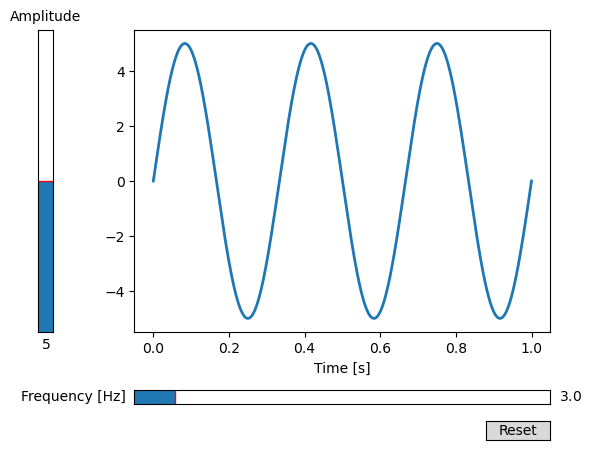

In [23]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.widgets import Button, Slider


# The parametrized function to be plotted
def f(t, amplitude, frequency):
    return amplitude * np.sin(2 * np.pi * frequency * t)

t = np.linspace(0, 1, 1000)

# Define initial parameters
init_amplitude = 5
init_frequency = 3

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = ax.plot(t, f(t, init_amplitude, init_frequency), lw=2)
ax.set_xlabel('Time [s]')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0.1,
    valmax=30,
    valinit=init_frequency,
)

# Make a vertically oriented slider to control the amplitude
axamp = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
amp_slider = Slider(
    ax=axamp,
    label="Amplitude",
    valmin=0,
    valmax=10,
    valinit=init_amplitude,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f(t, amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)
amp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    freq_slider.reset()
    amp_slider.reset()
button.on_clicked(reset)

plt.show()

# Filtrado de datos 

Promedia los datos de las muestras en grupos 

In [ ]:

carpeta_datos = r"C:\Users\dfgom\OneDrive\Escritorio\USRP\RFI_Captura\Salida\Muestras"

carpeta_tratadas = os.path.join(carpeta_datos, "Muestra_tratadas")
os.makedirs(carpeta_tratadas, exist_ok=True)

archivos_csv = [archivo for archivo in os.listdir(carpeta_datos) if archivo.endswith(".csv")]

# Función para promediar los datos en grupos 
def promediar_en_grupos(datos):
    grupos_promediados = []
    grupo_actual = []
    for i, fila in enumerate(datos):
        grupo_actual.append(fila)
        if (i + 1) % 10 == 0:
            promedio_grupo = [sum(col) / len(col) for col in zip(*grupo_actual)]
            grupos_promediados.append(promedio_grupo)
            grupo_actual = []
    if grupo_actual:
        promedio_grupo = [sum(col) / len(col) for col in zip(*grupo_actual)]
        grupos_promediados.append(promedio_grupo)
    return grupos_promediados

for archivo_csv in archivos_csv:
    # Leer el archivo CSV
    ruta_csv = os.path.join(carpeta_datos, archivo_csv)
    df = pd.read_csv(ruta_csv)

    # Promediar ambas columnas en grupos y crear un nuevo DataFrame
    grupos_promediados = promediar_en_grupos(df.values)
    df_promediado = pd.DataFrame(grupos_promediados, columns=["Promedio_Frecuencia (Hz)", "Promedio_dB"])

    # Generar el nombre del archivo filtrado
    nombre_filtrado = os.path.splitext(archivo_csv)[0] + "_filtrado.csv"
    ruta_filtrado = os.path.join(carpeta_tratadas, nombre_filtrado)

    df_promediado.to_csv(ruta_filtrado, index=False)

print("Archivos filtrados y promediados guardados en la carpeta 'Muestra_tratadas'.")

# pruebas con dataframe pequeño 


In [ ]:

archivo1 = r'C:\Users\dfgom\OneDrive\Escritorio\USRP\RFI_Captura\Salida\Muestras\Muestra_1.csv'
archivo2 = r'C:\Users\dfgom\OneDrive\Escritorio\USRP\RFI_Captura\Salida\Muestras\Muestra_2.csv'

df1 = pd.read_csv(archivo1)
df2 = pd.read_csv(archivo2)

tolerancia_frecuencia = 10000  # Ajusta este valor según tus necesidades

# Función para calcular el promedio de una agrupación
def calcular_promedio(group):
    return np.mean(group)

# Agrupa los datos por frecuencia dentro de la tolerancia y calcula el promedio utilizando NumPy
resultado_df1 = df1.groupby(pd.cut(df1['Frecuencia (Hz)'], bins=pd.interval_range(start=df1['Frecuencia (Hz)'].min(), end=df1['Frecuencia (Hz)'].max(), freq=tolerancia_frecuencia)))['dB'].agg(calcular_promedio).reset_index()
resultado_df2 = df2.groupby(pd.cut(df2['Frecuencia (Hz)'], bins=pd.interval_range(start=df2['Frecuencia (Hz)'].min(), end=df2['Frecuencia (Hz)'].max(), freq=tolerancia_frecuencia)))['dB'].agg(calcular_promedio).reset_index()

# Combinar los resultados de ambos DataFrames
resultado_combinado = pd.merge(resultado_df1, resultado_df2, on='Frecuencia (Hz)', suffixes=('_archivo1', '_archivo2'))

# Calcular el promedio de las columnas 'dB_archivo1' y 'dB_archivo2' y agregarlo como una tercera columna
resultado_combinado['Promedio_Total'] = (resultado_combinado['dB_archivo1'] + resultado_combinado['dB_archivo2']) / 2

# Guarda el DataFrame resultante en un archivo CSV
resultado_csv = 'resultado.csv'
resultado_combinado.to_csv(resultado_csv, index=False)

In [ ]:
# Leer el archivo CSV con los datos
archivo_csv = r'C:\Users\dfgom\OneDrive\Escritorio\USRP\RFI_Captura\Salida\Resultados\resultado_todos_los_datos.csv'
df = pd.read_csv(archivo_csv)

# Extraer las columnas de frecuencia y promedio
frecuencia = df['Frecuencia (Hz)'].to_numpy()
promedio = df['Promedio_Total'].to_numpy()

# Crear un gráfico de líneas
plt.figure(figsize=(12, 6))
plt.plot(frecuencia, promedio, marker='', linestyle='-')  # Utiliza 'o' para marcar los puntos

# Configurar etiquetas y título
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Promedio Total (dB)')
plt.title('Promedio Total por Intervalo de Frecuencia')

# Mostrar el gráfico
plt.xticks(rotation=45)
plt.grid(True)  # Agrega una cuadrícula para mayor claridad
plt.tight_layout()
plt.show()

In [3]:
valor1 = input("Ingresa el primer valor: ")

# Solicitar al usuario que ingrese el segundo valor
valor2 = input("Ingresa el segundo valor: ")

# Mostrar los valores ingresados por el usuario
print("Primer valor ingresado:", valor1)
print("Segundo valor ingresado:", valor2)

Primer valor ingresado: 20
Segundo valor ingresado: 34
